In [1]:
from IPython.display import SVG

import numpy as np
from scipy import sparse
from scipy.interpolate import interp1d

from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
import matplotlib.pyplot as plt


In [2]:
def matrice_adjacence(edge_list):
    """
    :para edge list 
    :type list
    :return matrice d'adjacence
    :rtype array (sparse matrix)
    cette fonction permet d'utiliser edge_list pour transmettre a une matrice d'adjacence.
    """
    adjacency = edgelist2adjacency(edge_list)
    myarray=adjacency.A
    n = myarray.shape[0]
    matrice = np.zeros((n,n))
    for i in range (myarray.shape[0]):
            matrice[i]=list(map(int, myarray[i]))
    return matrice

In [3]:
def matrice_degree(mat_adjacency):
    """
    :para une matrice d'adjacence 
    :type array (sparse matrix)
    :return une matrice degree 
    :rtype array (sparse matrix)
    cette fonction permet d'utiliser la matrice d'adjacence pour trouver la matrice degree
    la matrice des degrés est une matrice qui contient des informations sur le degré de chaque sommet d'un graphe.
    """
    n = mat_adjacency.shape[0]
    degree = np.zeros((n, n))
    temps = mat_adjacency.sum(axis = 1)
    for i in range(n):
        degree[i][i] = temps[i]
    return degree

In [4]:
def matrice_laplacien(mat_adjacency):
    """
    :para une matrice d'adjacence sparse
    :type array (sparse matrix)
    :return une matrice laplacienne
    :rtype array (sparse matrix)
    cette fonction permet d'utiliser la matrice d'adjacence pour trouver la matrice laplacienne
    la matrice laplacienne a une interprétation algébrique ce qui rend son analyse spectrale fructueuse.
    """
    degree = matrice_degree(mat_adjacency)
    res = degree - mat_adjacency
    return res

In [5]:
def make_random_adjacency(nbVertex):
    """
    :para nbVertex
    :type nt
    :return matrice d'adjacency
    :rtype array
    En savant le nombre de neoud, cette fontion est pour former une matrice d'adjacence random, car on ne peut pas lister tous les types manuellement
    """
    matrix = np.zeros((nbVertex, nbVertex))
    for i in range(nbVertex):
        for j in range(nbVertex):
            matrix[i][j] = np.random.randint(0,2) # ou round(np.random.rand())
        matrix[0][0]=1
    return matrix

In [6]:
def make_random_edgelist(nbVertex=4):
    """
    :para nbVertex
    :type int
    :return edgelist
    :rtype array
    En savant le nombre de noeud, cette fonction peut former une liste d'arrete aleatoirement.
    """
    maxNbEdges = (nbVertex**2)-nbVertex

    edgelist = list()
    for vertex in range(nbVertex):
        tab = np.arange(nbVertex)
        tab = np.delete(tab, vertex) # delete the current vertex
        nbEdges = np.random.randint(0, nbVertex) # generate number of edges of this vertex
        for i  in range(nbEdges):
            n = np.random.choice(tab)
            edgelist.append((vertex, n))
            indx, = np.where(tab==n)
            tab = np.delete(tab, indx) # update tab
    return edgelist

In [7]:
def make_random_adjacency_undirected(nbVertex):
    """
    :para nbVertex
    :type int
    :return matrice d'adjacency
    :rtype array
    cette fonction permet de former une matrice d'ajancence des graphes sans direction(undirected)
    Dans ce cas undirected, la matrice d'adjacence doit etre symetrique
    """
    matrix = np.zeros((nbVertex, nbVertex))
    while True:
        for i in range(nbVertex):
            for j in range(1+i, nbVertex):            
                matrix[i][j] = matrix[j][i] = np.random.randint(0,2)#Matrice symétriqueque 
        if 0 not in np.sum(matrix, axis=1):#Graphe sans noeud isolée filter les matrices avec noeud isolée
            break
    return matrix

In [8]:
def distance_2graph(matrice_G1, matrice_G2):
    """
    :para 2 matrices de 2 graphe,
    :type array (sparse matrix)
    :return distance entre 2 graphes 
    :rtype double
    en utilisant valeurs propres des matrices, cette fonction retourne la distance.
    Les matrices, elles sont souvent matrice d'adjacence. elles peuvent etre les matrices laplaciennes ou autres
    """
    VP1 = np.linalg.eig(matrice_G1)[0]#les valeurs propres de premier graph
    VP1 = np.array(sorted(VP1,reverse=True))#ordonner les valeurs propres
    VP2 = np.linalg.eig(matrice_G2)[0]#les valeurs propres de deuxieme graph
    VP2 = np.array(sorted(VP2,reverse=True))#ordonner 
    res = np.linalg.norm(VP1 - VP2)**2#sum des carrés de différence de VP
    return res

In [9]:
def distance_2graph_combine(adjacency_G1, adjacency_G2, alpha = 0.5):
    """
    :para 2 matrices d'adjancence, alpha qui define poids des adjacence et laplacien
    :type array (sparse matrix), alpha : double
    :return distance combine avec adjancence et laplacien
    :rtype double
    ici, on utilise αJSSA(G1, G2 ) + (1 − α)JSSL(G1, G2 ) (14) with α ∈ [0, 1], a weighting factor
    JSSA distance d'adjacence, JSSL distance de laplacien
    JSS : Joint Spectral Similarity voir l'article de reference
    alpha: weighting factor α controls the significance of each distance 
    and allows more importance to be given to the A-spectral distance or to the L-spectral distance.
    """
    JSSA = distance_2graph(adjacency_G1, adjacency_G2)
    JSSL = distance_2graph(matrice_laplacien(adjacency_G1), matrice_laplacien(adjacency_G2))
    JSS  = alpha * JSSA + (1 - alpha) * JSSL
    return JSS

In [10]:
def distance_2graphe_diff_vertex_simple(adjacency_G1, adjacency_G2, alpha = 0.5):
    """
    :para 2 matrices d'adjancence, alpha a weighting factor
    :type array, alpha : double
    :return distance entre 
    :rtype double
    cette fonction est une méthode simple pour calculer la distance entre 2 graphes avec noeuds differents
    comme le papier de Bay-Ahmed, on compte seulment les K premiers valeurs propres. k = min(N1, N2)
    """
    N1, N2 = adjacency_G1.shape[0], adjacency_G2.shape[0]
    k = min(N1, N2)
    VP1 = np.linalg.eig(adjacency_G1)[0]#les valeurs propres de premier graph
    VP1 = np.array(sorted(VP1,reverse=True))[:k]#ordonner les valeurs propres
    VP2 = np.linalg.eig(adjacency_G2)[0]#les valeurs propres de deuxieme graph
    VP2 = np.array(sorted(VP2,reverse=True))[:k]#ordonner 
    JSSA = np.linalg.norm(VP1 - VP2)**2#sum des carrés de différence de VP

    VP3 = np.linalg.eig(matrice_laplacien(adjacency_G1))[0]#les valeurs propres de premier graph
    VP3 = np.array(sorted(VP3,reverse=True))[:k]#ordonner les valeurs propres
    VP4 = np.linalg.eig(matrice_laplacien(adjacency_G2))[0]#les valeurs propres de deuxieme graph
    VP4 = np.array(sorted(VP4,reverse=True))[:k]#ordonner 
    JSSL = np.linalg.norm(VP3 - VP4)**2#sum des carrés de différence de VP

    JSS = alpha * JSSA + (1 - alpha) * JSSL
    return JSS
    

In [11]:
def line_topology(nbVertex=10):
    """
    :return array of matrix d'adjancence
    """
    res = np.zeros((nbVertex, nbVertex))
    for i in range(nbVertex-1):
        res[i+1, i] = 1
        res[i, i+1] = 1
    return res

In [12]:
def full_topology(nbVertex = 10):
    """
    :return array of matrix d'adjancence
    """
    res = np.ones((nbVertex, nbVertex))
    for i in range(nbVertex):
        res[i,i] = 0
    return res

In [13]:
def star_topology(nbVertex = 10):
    """
    :return array of matrix d'adjancence
    """
    res = np.zeros((nbVertex, nbVertex))
    for i in range(1, nbVertex):
        res[i,0] = 1
        res[0,i] = 1
    return res

In [14]:
def ring_topology(nbVertex = 10):
    """
    :return array of matrix d'adjancence
    """
    res = np.zeros((nbVertex, nbVertex))
    res[0, nbVertex-1] = 1
    res[nbVertex-1, 0] = 1
    for i in range(nbVertex-1):
        res[i+1, i] = 1
        res[i, i+1] = 1
    return res

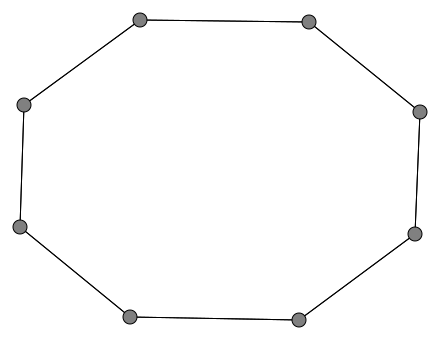

In [24]:
#adjacency = line_topology(8)
#adjacency = star_topology(8)
adjacency = ring_topology(8)
#adjacency = full_topology(8)
adjacency_matrix = sparse.csr_matrix(adjacency)

image = svg_graph(adjacency_matrix)
SVG(image)

In [16]:
def make_dataset(n = 10):
    """
    :return une liste de donnees des matrices d'adjacence
    """
    res = []
    for i in range(4,n):
        res.append(ring_topology(i))
        res.append(line_topology(i))
        res.append(full_topology(i))
        res.append(star_topology(i))
    return res

In [17]:
def interpolateEigenvalues(array1, array2, kind='linear'):
    """
    Fonction permettant d'interpoler l'ensemble des valeurs propre le plus petit pour avoir autant de valeur que dans le plus grand ensemble
    :param array1: tableau de valeurs propre
    :type array1: Numpy 1D array
    :param array2: tableau de valeurs propre
    :type array2: Numpy array
    :return: array1, array2
    :rtype: Numpy 1d Array, Numpy 1d Array
    """
    minArray = array1
    maxArray = array2
    if array1.shape[0]>array2.shape[0]:
        minArray = array2
        maxArray = array1
    elif array1.shape[0]==array2.shape[0]:
        return array1, array2

    common_x = np.linspace(0, 1, len(maxArray))
    x = np.linspace(0, 1, len(minArray))
    f = interp1d(x, np.array(sorted(minArray,reverse=True)), kind=kind)
    min1dArrayInterpolated = f(common_x)
    
    # ordered arrays
    min1dArrayInterpolated = np.array(sorted(min1dArrayInterpolated,reverse=True))
    maxArray = np.array(sorted(maxArray,reverse=True))

    if array1.shape[0]>array2.shape[0]:
        return maxArray, min1dArrayInterpolated
    return min1dArrayInterpolated, maxArray

In [2]:
def linInterpolateEigenvalues(array1, array2):
    """
    Fonction permettant d'interpoler l'ensemble des valeurs propre le plus petit pour avoir autant de valeur que dans le plus grand ensemble
     
    :param array1: tableau de valeurs propre
    :type array1: Numpy 1D array
    :param array2: tableau de valeurs propre
    :type array2: Numpy array
    :return: array1, array2
    :rtype: Numpy 1d Array, Numpy 1d Array
    """
    minArray = array1
    maxArray = array2
    if array1.shape[0]>array2.shape[0]:
        minArray = array2
        maxArray = array1
    elif array1.shape[0]==array2.shape[0]:
        return array1, array2
    
    x = np.linspace(0,1, len(maxArray))
    xp = np.linspace(0,1, len(minArray))
    fp = np.array(sorted(minArray,reverse=True))
    min1dArrayInterpolated = np.interp(x, xp, fp)
    
    # ordered arrays
    min1dArrayInterpolated = np.array(sorted(min1dArrayInterpolated,reverse=True))
    maxArray = np.array(sorted(maxArray,reverse=True))

    if array1.shape[0]>array2.shape[0]:
        return maxArray, min1dArrayInterpolated
    return min1dArrayInterpolated, maxArray

In [19]:
def distance_2graphe_diff_vertex_v2(adjacency_G1, adjacency_G2, alpha = 0.5):
    """
    Version 2 de la méthode de calcul de distance avec 2 graphes n'ayant pas le même nombre de noeuds.
    Cette version 2 consiste à interpoller l'ensemble des valeurs propres le plus petit pour avoir deux ensembles de mêmes taille à comparer
    :para 2 matrices d'adjancence, alpha a weighting factor
    :type array, alpha : double
    :return distance entre 
    :rtype double
    cette fonction est une méthode simple pour calculer la distance entre 2 graphes avec noeuds differents
    comme le papier de Bay-Ahmed, on compte seulment les K premiers valeurs propres. k = min(N1, N2)
    """
    VP1 = np.linalg.eig(adjacency_G1)[0]#les valeurs propres de premier graph
    VP2 = np.linalg.eig(adjacency_G2)[0]#les valeurs propres de deuxieme graph
    VP1, VP2 = interpolateEigenvalues(VP1, VP2, kind='nearest')
    #VP1 = np.array(sorted(VP1,reverse=True))# ordonner les valeurs propres
    #VP2 = np.array(sorted(VP2,reverse=True)) 

    JSSA = np.linalg.norm(VP1 - VP2)**2#sum des carrés de différence de VP

    VP3 = np.linalg.eig(matrice_laplacien(adjacency_G1))[0]#les valeurs propres de premier graph
    VP4 = np.linalg.eig(matrice_laplacien(adjacency_G2))[0]#les valeurs propres de deuxieme graph
    VP3, VP4 = interpolateEigenvalues(VP3, VP4, kind='nearest')
    #VP3 = np.array(sorted(VP3,reverse=True))# ordonner les valeurs propres
    #VP4 = np.array(sorted(VP4,reverse=True)) 

    JSSL = np.linalg.norm(VP3 - VP4)**2#sum des carrés de différence de VP

    JSS = alpha * JSSA + (1 - alpha) * JSSL
    return JSS

In [20]:
def identifier(dataset, matrice_ajacence):
    """
    cette fonction permet de trouver les graphes similaires en savant une matrice d'adjacence
    :return on retourne les 4 ids des primiers similaire graphes
    """
    res = []
    distance = {}
    for i in range(len(dataset)):
        distance[i] = distance_2graphe_diff_vertex_v2(dataset[i], matrice_ajacence)#distance_2graphe_diff_vertex_v2
        #distance_2graphe_diff_vertex_simple
    ids = []
    for i in sorted(distance.items(), key = lambda x: x[1])[:4]:
        id, _ = i
        ids.append(id)
    return ids

In [25]:
dataset = make_dataset()
len(dataset)

24

In [33]:
#0，4，8，12, 16 sont le même type
#i, i+4*n
identifier(dataset, dataset[7])

[7, 11, 3, 0]

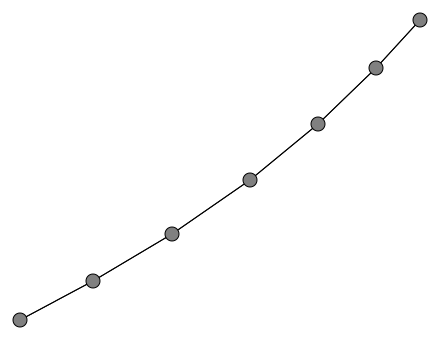

In [32]:
mat = dataset[13]
adjacency_matrix = sparse.csr_matrix(mat)
image = svg_graph(adjacency_matrix)
SVG(image)

In [21]:
#adjacency1 = make_random_adjacency_undirected(nbVertex = 4)
#adjacency2 = make_random_adjacency_undirected(nbVertex = 4)

#adjacency1_matrix = sparse.csr_matrix(adjacency1)
#adjacency2_matrix = sparse.csr_matrix(adjacency2)

#image1 = svg_graph(adjacency1_matrix)
#SVG(image1)
#image2 = svg_graph(adjacency2_matrix)
#SVG(image2)

In [22]:
# comparer distance d'adjacence et celle de laplacien 
for i in range(10):
    adjacency1 = make_random_adjacency_undirected(nbVertex = 5)
    adjacency2 = make_random_adjacency_undirected(nbVertex = 5)
    #distance en utilisant matrice d'adjacence
    #print("distance(matrice adjacence): ", distance_2graph(adjacency1, adjacency2))
    dis_adjacence = distance_2graph(adjacency1, adjacency2)
    #distance en utilisant matrice laplacienne
    dis_laplacien = distance_2graph(matrice_laplacien(adjacency1), matrice_laplacien(adjacency2))
    #print("distance(matrice laplacien): ", distance_2graph(laplacien1, laplacien2))
    difference = dis_laplacien - dis_adjacence
    print("diff :", difference, "positif :", difference > -1e-10)

diff : 8.278237474835889 positif : True
diff : -0.35021843538204617 positif : False
diff : 4.744328118005619 positif : True
diff : 3.580371444437827 positif : True
diff : 12.87926337154074 positif : True
diff : 7.88033742803064 positif : True
diff : 1.100327938359513 positif : True
diff : 1.5141067428303903 positif : True
diff : 0.6171868831675558 positif : True
diff : 0.19799584912866797 positif : True


In [23]:
#on trouve ce-dessus, principalement distance_laplacien >= distance_adjacence, sauf quelques exemples
#on trouve un exemple special ci-dessous
special1 = np.array([[0., 1., 1., 0., 0.],
                     [1., 0., 0., 0., 1.],
                     [1., 0., 0., 1., 1.],
                     [0., 0., 1., 0., 0.],
                     [0., 1., 1., 0., 0.]])
special2 = np.array([[0., 1., 1., 0., 0.],
                     [1., 0., 1., 0., 0.],
                     [1., 1., 0., 0., 1.],
                     [0., 0., 0., 0., 1.],
                     [0., 0., 1., 1., 0.]])
special_adjacence = distance_2graph(special1, special2)
special_laplacien = distance_2graph(matrice_laplacien(special1), matrice_laplacien(special2))
special_difference = special_laplacien - special_adjacence
print(special_difference)

-0.35021843538205116


In [24]:
#tests pour la distance combinee
for i in range(10):
    adjacency1 = make_random_adjacency_undirected(nbVertex = 5)
    adjacency2 = make_random_adjacency_undirected(nbVertex = 5)
    dis_adjacence = distance_2graph(adjacency1, adjacency2)
    dis_laplacien = distance_2graph(matrice_laplacien(adjacency1), matrice_laplacien(adjacency2))
    dis_combine = distance_2graph_combine(adjacency1, adjacency2, alpha=0.5)
    print("JSSA :", dis_adjacence, "JSSL :", dis_laplacien, "JSS :", dis_combine) 

JSSA : 1.414646414705633 JSSL : 4.357265445311824 JSS : 2.8859559300087283
JSSA : 2.8236712135978412 JSSL : 10.979481080243792 JSS : 6.901576146920816
JSSA : 1.8957324923702858 JSSL : 4.357265445311824 JSS : 3.1264989688410547
JSSA : 2.2444144683783303 JSSL : 10.000000000000009 JSS : 6.12220723418917
JSSA : 0.1532457024891129 JSSL : 1.1056589431444694 JSS : 0.6294523228167912
JSSA : 3.1207366284592766 JSSL : 16.00000000000002 JSS : 9.560368314229649
JSSA : 0.24025874325893015 JSSL : 0.5835921350012598 JSS : 0.411925439130095
JSSA : 5.128619265943245 JSSL : 26.000000000000032 JSS : 15.56430963297164
JSSA : 0.7768940008740026 JSSL : 4.35726544531182 JSS : 2.5670797230929114
JSSA : 5.62352912087123e-30 JSSL : 7.947176958793934e-30 JSS : 6.785353039832582e-30


### test sur les graphes ayant des topologies similaires puis de plus en plus différentes, pour vérifier que la distance reflète bien ces différences

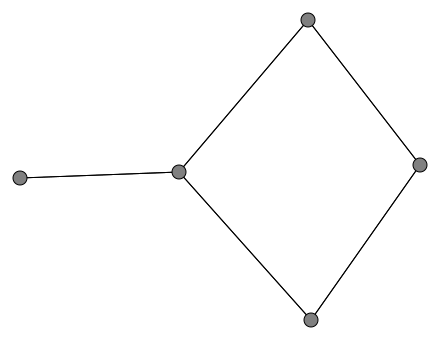

In [25]:
adjacency1 = np.array([[0., 1., 1., 0., 0.],
                       [1., 0., 0., 0., 1.],
                       [1., 0., 0., 1., 1.],
                       [0., 0., 1., 0., 0.],
                       [0., 1., 1., 0., 0.]])
adjacency1_matrix = sparse.csr_matrix(adjacency1)

image1 = svg_graph(adjacency1_matrix)
SVG(image1)

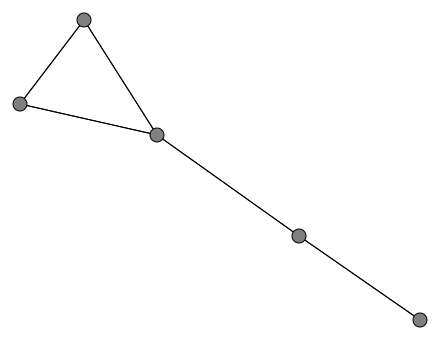

In [26]:
adjacency2 = np.array([[0., 1., 1., 0., 0.],
                       [1., 0., 1., 0., 0.],
                       [1., 1., 0., 0., 1.],
                       [0., 0., 0., 0., 1.],
                       [0., 0., 1., 1., 0.]])
adjacency2_matrix = sparse.csr_matrix(adjacency2)

image2 = svg_graph(adjacency2_matrix)
SVG(image2)

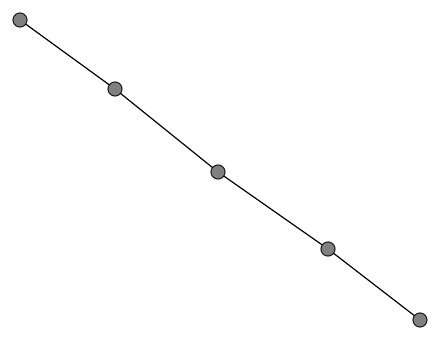

In [27]:
adjacency3 = np.array([[0., 1., 0., 0., 0.],
                       [1., 0., 1., 0., 0.],
                       [0., 1., 0., 1., 0.],
                       [0., 0., 1., 0., 1.],
                       [0., 0., 0., 1., 0.]])
adjacency3_matrix = sparse.csr_matrix(adjacency3)

image3 = svg_graph(adjacency3_matrix)
SVG(image3)

In [28]:
d_1_2 = distance_2graph_combine(adjacency1, adjacency2, alpha = 0.55)
d_2_3 = distance_2graph_combine(adjacency2, adjacency3, alpha = 0.5)
d_1_3 = distance_2graph_combine(adjacency1, adjacency3, alpha = 0.5)
print(" distance entre no.1 et no.2 :", d_1_2, "\n distance entre no.2 et no.3 :", d_2_3, "\n distance entre no.1 et no.3 :", d_1_3)
# les resultats montrent pas mal

 distance entre no.1 et no.2 : 0.5797724358139108 
 distance entre no.2 et no.3 : 0.9296187178771995 
 distance entre no.1 et no.3 : 0.943481707174449


## test pour les graphes avec différents noeuds

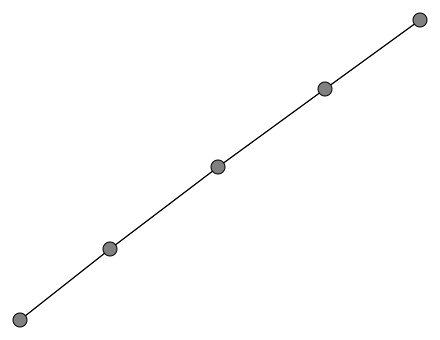

In [29]:
# test pour les graphes avec différents noeuds
adjacency1 = np.array([[0., 1., 0., 0., 0.],
                       [1., 0., 1., 0., 0.],
                       [0., 1., 0., 1., 0.],
                       [0., 0., 1., 0., 1.],
                       [0., 0., 0., 1., 0.]])
adjacency1_matrix = sparse.csr_matrix(adjacency1)

image1 = svg_graph(adjacency1_matrix)
SVG(image1)

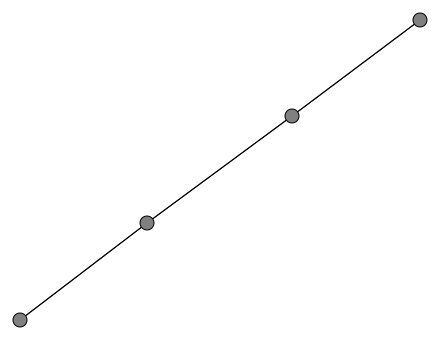

In [30]:
adjacency2 = np.array([[0., 1., 0., 0.],
                       [1., 0., 1., 0.],
                       [0., 1., 0., 1.],
                       [0., 0., 1., 0.]])
adjacency2_matrix = sparse.csr_matrix(adjacency2)

image2 = svg_graph(adjacency2_matrix)
SVG(image2)

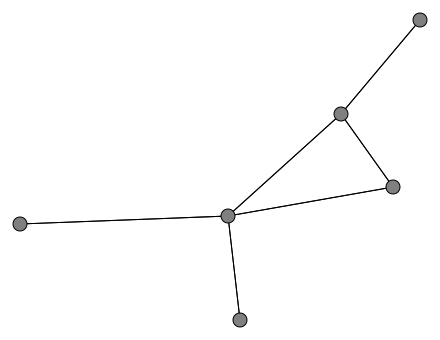

In [31]:
adjacency3 = np.array([[0., 1., 0., 0., 0., 0.],
                       [1., 0., 1., 1., 1., 0.],
                       [0., 1., 0., 0., 0., 0.],
                       [0., 1., 0., 0., 1., 0.],
                       [0., 1., 0., 1., 0., 1.],
                       [0., 0., 0., 0., 1., 0.]])
adjacency3_matrix = sparse.csr_matrix(adjacency3)

image3 = svg_graph(adjacency3_matrix)
SVG(image3)

In [32]:
d_1_2 = distance_2graphe_diff_vertex_simple(adjacency1, adjacency2)
d_2_3 = distance_2graphe_diff_vertex_simple(adjacency2, adjacency3)
d_1_3 = distance_2graphe_diff_vertex_simple(adjacency1, adjacency3)
print(" distance entre no.1 et no.2 :", d_1_2, "\n distance entre no.2 et no.3 :", d_2_3, "\n distance entre no.1 et no.3 :", d_1_3)
# on voit cette methode est simple, mais parfois ca marche

 distance entre no.1 et no.2 : 1.0630693079438962 
 distance entre no.2 et no.3 : 5.783771300451879 
 distance entre no.1 et no.3 : 3.028004723710413


In [33]:
def interpolateEigenvalues(array1, array2):
    """
    Fonction permettant d'interpoler l'ensemble des valeurs propre le plus petit pour avoir autant de valeur que dans le plus grand ensemble
    :param array1: tableau de valeurs propre
    :type array1: Numpy 1D array
    :param array2: tableau de valeurs propre
    :type array2: Numpy array
    :return: array1, array2
    :rtype: Numpy 1d Array, Numpy 1d Array
    """
    minArray = array1
    maxArray = array2
    if array1.shape[0]>array2.shape[0]:
        minArray = array2
        maxArray = array1
    elif array1.shape[0]==array2.shape[0]:
        return array1, array2

    common_x = np.linspace(0, 1, len(maxArray))
    x = np.linspace(0, 1, len(minArray))
    f = interp1d(x, minArray)
    min1dArrayInterpolated = f(common_x)

    if array1.shape[0]>array2.shape[0]:
        return maxArray, min1dArrayInterpolated
    return min1dArrayInterpolated, maxArray

In [34]:
def distance_2graphe_diff_vertex_v2(adjacency_G1, adjacency_G2, alpha = 0.5):
    """
    Version 2 de la méthode de calcul de distance avec 2 graphes n'ayant pas le même nombre de noeuds.
    Cette version 2 consiste à interpoller l'ensemble des valeurs propres le plus petit pour avoir deux ensembles de mêmes taille à comparer
    :para 2 matrices d'adjancence, alpha a weighting factor
    :type array, alpha : double
    :return distance entre 
    :rtype double
    cette fonction est une méthode simple pour calculer la distance entre 2 graphes avec noeuds differents
    comme le papier de Bay-Ahmed, on compte seulment les K premiers valeurs propres. k = min(N1, N2)
    """
    VP1 = np.linalg.eig(adjacency_G1)[0]#les valeurs propres de premier graph
    VP2 = np.linalg.eig(adjacency_G2)[0]#les valeurs propres de deuxieme graph
    VP1, VP2 = interpolateEigenvalues(VP1, VP2)
    VP1 = np.array(sorted(VP1,reverse=True))# ordonner les valeurs propres
    VP2 = np.array(sorted(VP2,reverse=True)) 

    JSSA = np.linalg.norm(VP1 - VP2)**2#sum des carrés de différence de VP

    VP3 = np.linalg.eig(matrice_laplacien(adjacency_G1))[0]#les valeurs propres de premier graph
    VP4 = np.linalg.eig(matrice_laplacien(adjacency_G2))[0]#les valeurs propres de deuxieme graph
    VP3, VP4 = interpolateEigenvalues(VP3, VP4)
    VP3 = np.array(sorted(VP3,reverse=True))# ordonner les valeurs propres
    VP4 = np.array(sorted(VP4,reverse=True)) 

    JSSL = np.linalg.norm(VP3 - VP4)**2#sum des carrés de différence de VP

    JSS = alpha * JSSA + (1 - alpha) * JSSL
    return JSS

In [35]:
print("Nombre de noeuds G1 ", adjacency1.shape[0], "; G2 ", adjacency2.shape[0], "; G3 ", adjacency3.shape[0])
d_1_2 = distance_2graphe_diff_vertex_v2(adjacency1, adjacency2)
d_2_3 = distance_2graphe_diff_vertex_v2(adjacency2, adjacency3)
d_1_3 = distance_2graphe_diff_vertex_v2(adjacency1, adjacency3)
print("Méthode avec interpollation de l'ensemble des valeurs propre le plus petit")
print("Distance entre no.1 et no.2 :", d_1_2, "\n distance entre no.2 et no.3 :", d_2_3, "\n distance entre no.1 et no.3 :", d_1_3)
# on voit cette methode est simple, mais parfois ca marche

Nombre de noeuds G1  5 ; G2  4 ; G3  6
Méthode avec interpollation de l'ensemble des valeurs propre le plus petit
Distance entre no.1 et no.2 : 0.43960065180372127 
 distance entre no.2 et no.3 : 3.451132326030513 
 distance entre no.1 et no.3 : 2.4064658643902472


In [36]:
import re
import ast

In [37]:

def read_data_file(number_of_graphs=2):
    reg = re.compile(r'((\{"(?P<name>\w+)",\s((\{.+\})|(\d+))\})|("(?P<name1>\w+)")),\s(?P<values>\{\{.*\}\})')
    d = []
    with open("./data_graphs.txt") as infile:
        i = number_of_graphs
        for line in infile:
            if i==0:
                break
            match = reg.search(line[1:-2])
            if match:
                name = match.group('name') if match.group('name1') is None else match.group('name1')
                values = match.group('values').replace("{","[").replace("}", "]")
                d.append((name, ast.literal_eval(values)))

            i -= 1
    return d

In [38]:
graph_dataset = read_data_file(2)

adjacency = edgelist2adjacency(graph_dataset[0][1])

image = svg_digraph(adjacency)
SVG(image)

FileNotFoundError: [Errno 2] No such file or directory: './data_graphs.txt'

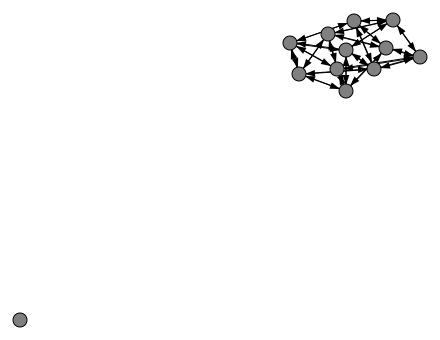

In [138]:
adjacency1 = edgelist2adjacency(graph_dataset[1][1])

image1 = svg_digraph(adjacency1)
SVG(image1)

In [144]:
distance_2graphe_diff_vertex_simple(matrice_adjacence(graph_dataset[0][1]), matrice_adjacence(graph_dataset[1][1]))

47.38762817710092

In [145]:
distance_2graphe_diff_vertex_v2(matrice_adjacence(graph_dataset[0][1]), matrice_adjacence(graph_dataset[1][1]))

36.961560664315506